In [315]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd
from tqdm import tqdm

# Helper functions

In [288]:
def plot_hist(returns):
    
    zeta = 0.05
    alpha = 0.05
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.axvline(var, c='y', linestyle='--', label=f'VaR={var:4.2}')
    plt.axvline(cvar, c='r', linestyle='--', label=f'CVaR={cvar:4.2}')
    plt.axvline(zeta, c='g', linestyle='--', label=f'P={p}')
    plt.legend()

In [289]:
def plot_2d(returns):
    
    n_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(n_assets):
        for j in range(n_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')
        ax[i][i].legend()

# Generate returns

In [575]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.repeat(0.03, 7)

In [576]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.58it/s]


In [577]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,-0.004596,-0.015041,-0.122165,-0.067485,0.038354,-0.094799,-0.093600
1,0.133764,0.147677,0.028209,0.072532,0.079053,0.202910,-0.013636
2,0.209864,0.134214,0.031338,0.185061,0.116217,0.182734,0.097845
3,0.054241,-0.027154,0.172261,0.120942,0.194992,-0.057266,-0.003210
4,0.222276,0.171140,0.027434,0.066270,0.433530,0.119981,0.002489
...,...,...,...,...,...,...,...
995,0.018749,0.161323,0.136476,0.169215,0.091814,0.215293,0.058009
996,0.205006,0.114523,0.211715,0.056147,0.359615,0.109495,0.054707
997,0.186818,0.133087,0.086944,0.076899,0.265965,0.963528,0.065816
998,-0.073580,0.089704,0.263296,0.090763,0.035643,0.002980,-0.018833


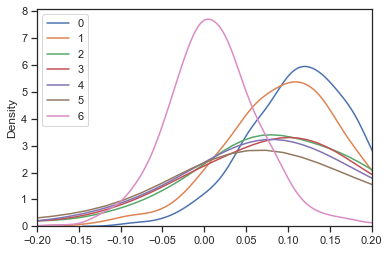

In [293]:
# 1d marginals on top of each other

for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

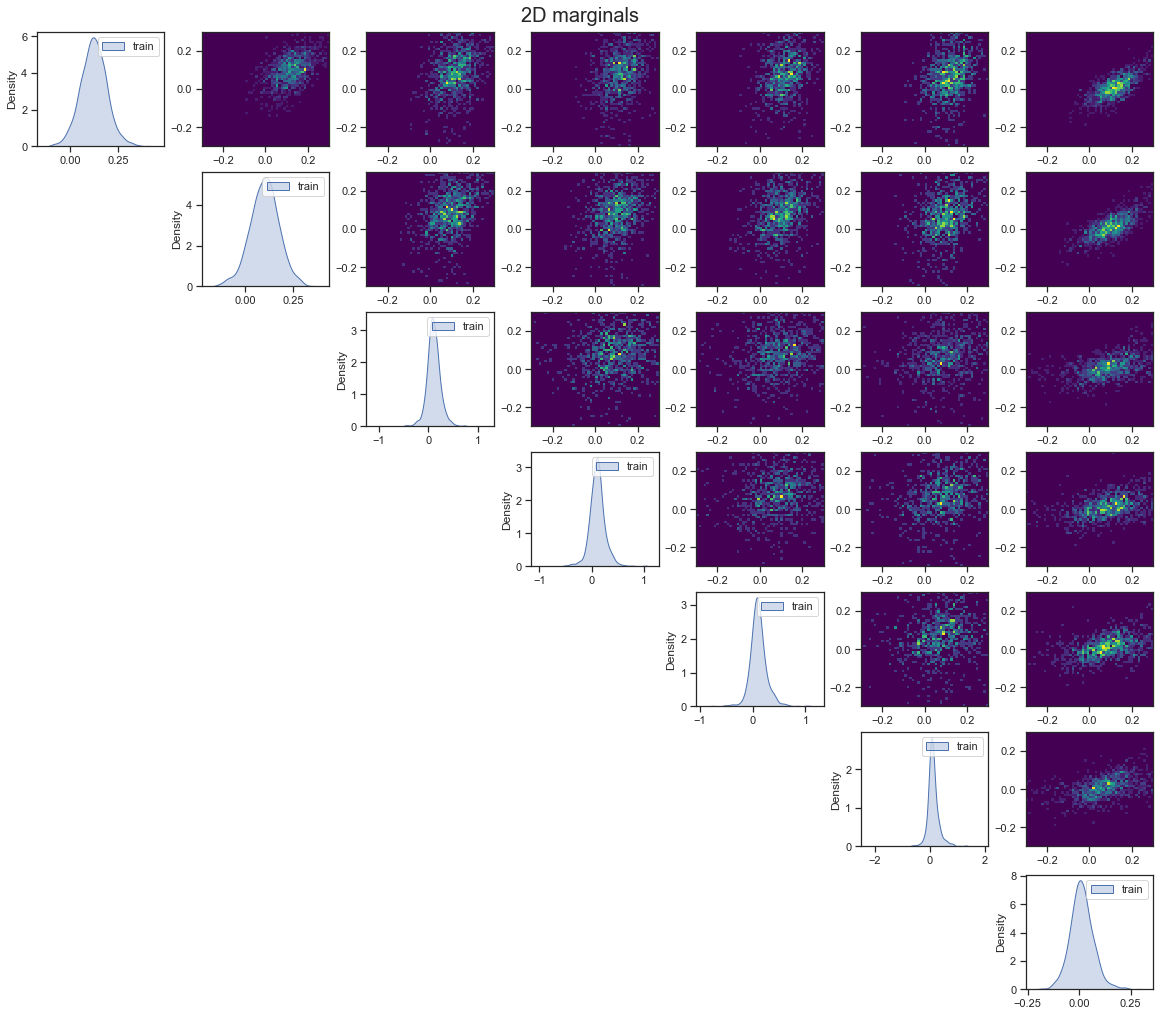

In [294]:
plot_2d(log_ret)

# Averages of empirical CDF vs. empirical CDF of averages

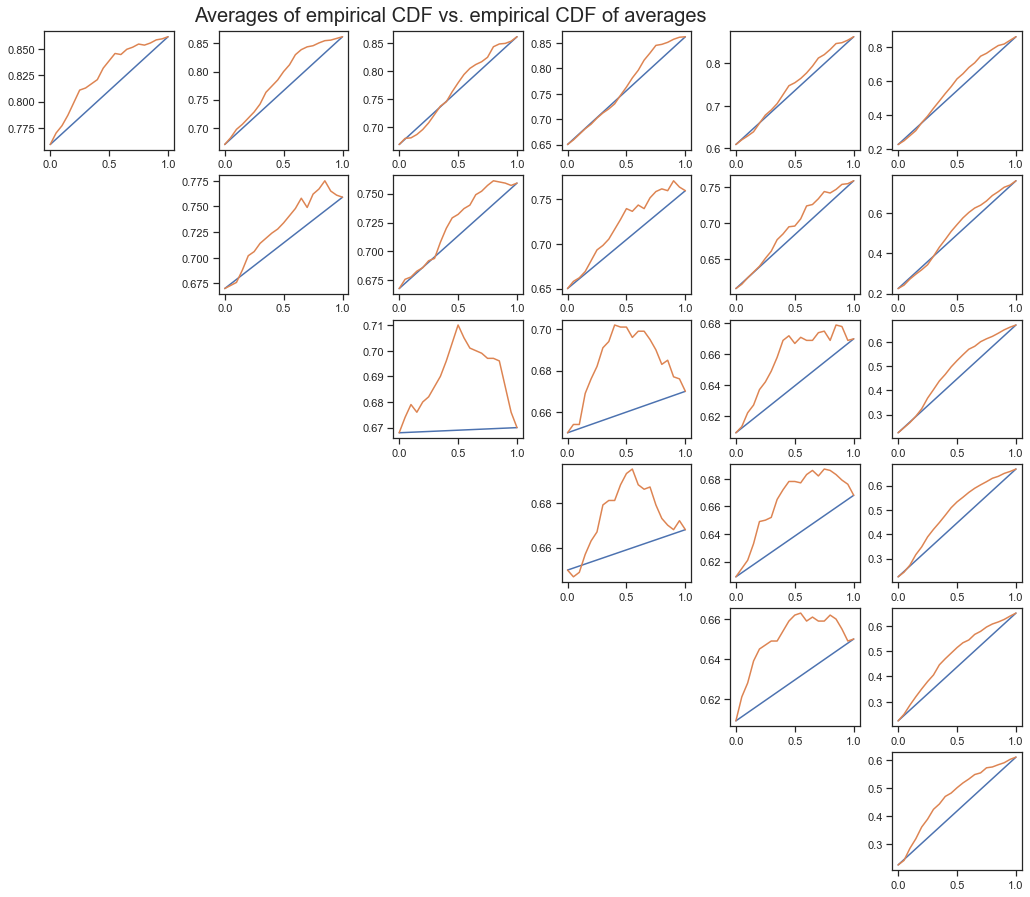

In [307]:
n_assets = 7

fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
fig.suptitle('Averages of empirical CDF vs. empirical CDF of averages', fontsize=20)

for i in range(n_assets):
    for j in range(n_assets):
        if i < j:
            q0, q1 = np.mean(log_ret[:, i] >= 0.05), np.mean(log_ret[:, j] >= 0.05)

            ws = np.linspace(0, 1, 21)
            ps0 = ws * q0 + (1 - ws) * q1
            ps1 = np.mean(ws[:, None] @ log_ret[:, i][None, :] + ((1 - ws[:, None]) @ log_ret[:, j][None, :]) >= 0.05, axis=1)

            ax[i][j].plot(ws, ps0)
            ax[i][j].plot(ws, ps1)
            
        if i >= j:
            fig.delaxes(ax[i][j])


# Correlation of returns

In [308]:
df = pd.DataFrame(log_ret)
mean = pd.DataFrame(df.mean(axis=0)).T
display(mean.style.background_gradient(cmap='coolwarm', axis=None))
corr = df.corr()
display(corr.style.background_gradient(cmap='coolwarm', axis=None))

,0,1,2,3,4,5,6
0,0.121659,0.099129,0.102485,0.101956,0.101870,0.109624,0.011680


,0,1,2,3,4,5,6
0,1.000000,0.499247,0.281160,0.195001,0.196805,0.184291,0.721614
1,0.499247,1.000000,0.271915,0.171558,0.190190,0.129133,0.708985
2,0.281160,0.271915,1.000000,0.147750,0.145957,0.066786,0.380239
3,0.195001,0.171558,0.147750,1.000000,0.117084,0.085010,0.296409
4,0.196805,0.190190,0.145957,0.117084,1.000000,0.063009,0.301520
5,0.184291,0.129133,0.066786,0.085010,0.063009,1.000000,0.214233
6,0.721614,0.708985,0.380239,0.296409,0.301520,0.214233,1.000000


# Optimization with riskfolio

In [309]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1,2,3,4,5,6
weights,0.676062,0.229646,0.017478,0.035875,0.027266,0.013671,1.033150e-14


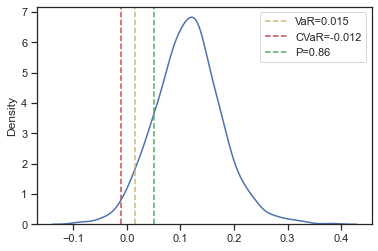

In [572]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

Objective: 14.637130055895962
Portfolio weights:


,0,1,2,3,4,5,6
0,0.543129,0.293144,0.060016,0.08345,0.020261,-1.175879e-07,-3.572598e-07


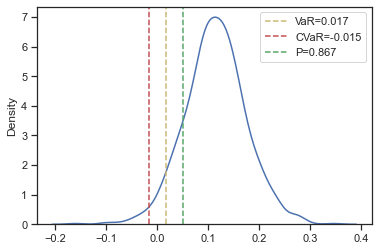

In [668]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np

returns = log_ret
alpha = 0.05

n_returns, n_assets = returns.shape

weights = cp.Variable((n_assets,))
X = returns @ weights

Z = cp.Variable((n_returns,))
var = cp.Variable((1,))
cvar = var + 1 / (alpha * n_returns) * cp.sum(Z)

constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]

# CVaR constraints
constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

# lower bound: average of emp cdf:
# might not be a valid constraint!
emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
constraints += [emp_cdf_005 @ weights * 1000 >= 0.8 * 1000]

# naive idea for the return constraint:
# constraints += [cp.sum(returns @ weights >= 0.05) >= 0.7 * n_returns]

# normal approximation
mean_assets, cov_assets = df.mean().to_numpy(), df.cov().to_numpy()

objective = cp.Minimize(cvar * 1000)

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective: {result}")

portfolio_weights = weights.value
portfolio_returns = returns @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns)

# Normal approximation

In [441]:
mean, var = portfolio_weights @ df.mean(), portfolio_weights @ df.cov() @ portfolio_weights.T
mean, var

(0.11019868053767609, 0.003771111954957206)

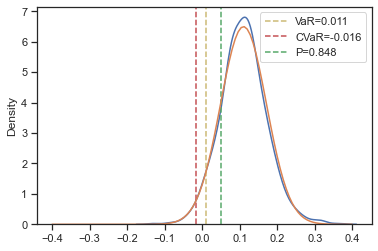

In [442]:
plot_hist(portfolio_returns)
xs = np.linspace(-0.4, 0.4, 101)
ys = norm.pdf(xs, loc=mean, scale=np.sqrt(var))
plt.plot(xs, ys)

In [443]:
# simple approximation from here:
# https://edarchimbaud.com/glossary/value-at-risk#6f6ed73a1dfd42d4a47135a1f8db3912
mean - 0.2 * np.sqrt(var)

0.09791680453283513

In [447]:
from scipy.special import erf

In [ ]:
norm.cdf((0.05 - mean) / np.sqrt(var)), erf(np.sqrt(2) * (0.05 - mean) / np.sqrt(var))

(0.1634727829269631, -0.9500707436168888)

In [ ]:
cp.log_normcdf((0.05 - mean) / np.sqrt(var)) <= np.log(0.3)

Inequality(Expression(CONSTANT, NONPOSITIVE, ()))

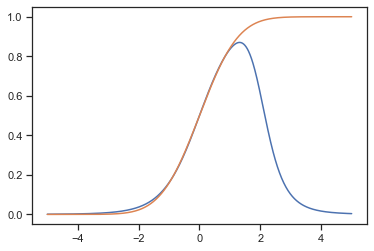

In [ ]:
xs = np.linspace(-5, 5, 1001)
# ys = 1 / (1 + np.exp(-1.65451 * xs))
ys = 1 / (2 - 1.65451 * xs + (-1.65451 * xs)**2 / 2 + (-1.65451 * xs)**3/6 + (-1.65451 * xs)**4/24 + (-1.65451 * xs)**5/120 + (-1.65451 * xs)**6/720)
zs = norm.cdf(xs)
plt.plot(xs, ys)
plt.plot(xs, zs)